# EEG Preprocessing for Campeones Analysis Project - Variable Duration Epochs

The following script performs EEG data preprocessing for the Campeones Analysis dataset using **variable duration epochs** based on merged_events. Each video stimulus has its own duration, so epochs are created individually.

## Processing Steps:

1. **Load raw data** - BrainVision format (.vhdr, .vmrk, .eeg files)
2. **Load merged events** - Events with real onset times and variable durations
3. **Band pass filter** - 0.5 to 45 Hz with notch filter for line noise
4. **Visual inspection of channels** - Identify and mark bad channels  
5. **Variable Duration Epoching** - Create individual epochs for each event (-0.3s to event duration)
6. **Autoreject Epochs** - Apply AutoReject to each epoch individually
7. **Manual inspection of Epochs** - Visual inspection and manual rejection
8. **ICA** - Independent Component Analysis for artifact removal
9. **Baseline correction** - Apply baseline using pre-stimulus period (-0.3s to 0s)
10. **Interpolate bad channels** - Spherical spline interpolation
11. **Re-reference** - Grand average reference
12. **Save preprocessed data** - Export each epoch individually to BIDS derivatives

## Key Features:
- **Variable Duration Support**: Each video stimulus can have different duration
- **Individual Processing**: Each epoch is processed separately through the pipeline
- **Baseline Correction**: Uses pre-stimulus period for baseline correction
- **Event Metadata**: Preserves trial type, duration, and onset information

**Current Configuration:**
- Subject: sub-16
- Session: vr  
- Task: 02
- Acquisition: b
- Run: 008
- Data Source: `./data/derivatives/merged_events/`

In [9]:

# This magic command allows interactive plotting in a separate window
%matplotlib widget


# Import necessary libraries for the preprocessing
import os
import sys
from git import Repo
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import mne
from mne_bids import BIDSPath, read_raw_bids #,print_dir_tree
# Importing libraries for automatic rejection of bad epochs
from autoreject import AutoReject, get_rejection_threshold
from pyprep import NoisyChannels

# tag automatically ICA components
# requires pytorch
from mne_icalabel import label_components

# Add src directory to Python path to enable imports
repo = Repo(os.getcwd(), search_parent_directories=True)
repo_root = repo.git.rev_parse("--show-toplevel")
src_path = os.path.join(repo_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import helper functions for preprocessing
from campeones_analysis.utils.log_preprocessing import LogPreprocessingDetails
from campeones_analysis.utils import bids_compliance


# 1. Load Data

Embedding : jquery-3.6.0.min.js
Embedding : bootstrap.bundle.min.js
Embedding : bootstrap.min.css
Embedding : bootstrap-table/bootstrap-table.min.js
Embedding : bootstrap-table/bootstrap-table.min.css
Embedding : bootstrap-table/bootstrap-table-copy-rows.min.js
Embedding : bootstrap-table/bootstrap-table-export.min.js
Embedding : bootstrap-table/tableExport.min.js
Embedding : bootstrap-icons/bootstrap-icons.mne.min.css
Embedding : highlightjs/highlight.min.js
Embedding : highlightjs/atom-one-dark-reasonable.min.css
Extracting parameters from C:\Users\tdamelio\Desktop\campeones_analysis\data\raw\sub-16\ses-vr\eeg\sub-16_ses-vr_task-02_acq-b_run-008_eeg.vhdr...
Setting channel info structure...
Reading events from C:\Users\tdamelio\Desktop\campeones_analysis\data\raw\sub-16\ses-vr\eeg\sub-16_ses-vr_task-02_acq-b_run-008_events.tsv.
Reading channel info from C:\Users\tdamelio\Desktop\campeones_analysis\data\raw\sub-16\ses-vr\eeg\sub-16_ses-vr_task-02_acq-b_run-008_channels.tsv.
Reading el

C:\Users\tdamelio\AppData\Local\Temp\ipykernel_13748\2405519912.py:61: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['ECG', 'R_EYE', 'L_EYE', 'AUDIO', 'PHOTO', 'GSR', 'RESP', 'X', 'Y', 'Z', 'joystick_x', 'joystick_y']
  raw = read_raw_bids(bids_path)
C:\Users\tdamelio\AppData\Local\Temp\ipykernel_13748\2405519912.py:61: RuntimeWarning: Not setting positions of 12 ecg/eog/gsr/misc/resp channels found in montage:
['ECG', 'R_EYE', 'L_EYE', 'AUDIO', 'PHOTO', 'GSR', 'RESP', 'X', 'Y', 'Z', 'joystick_x', 'joystick_y']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path)
C:\Users\tdamelio\AppData\Local\Temp\ipykernel_13748\2405519912.py:61: RuntimeWarning: Unable to map the following column(s) to to MNE:
species: n/a
birth_date: n/a
gender: n/a
handedness: n/a
education_level: n/a
university_ca

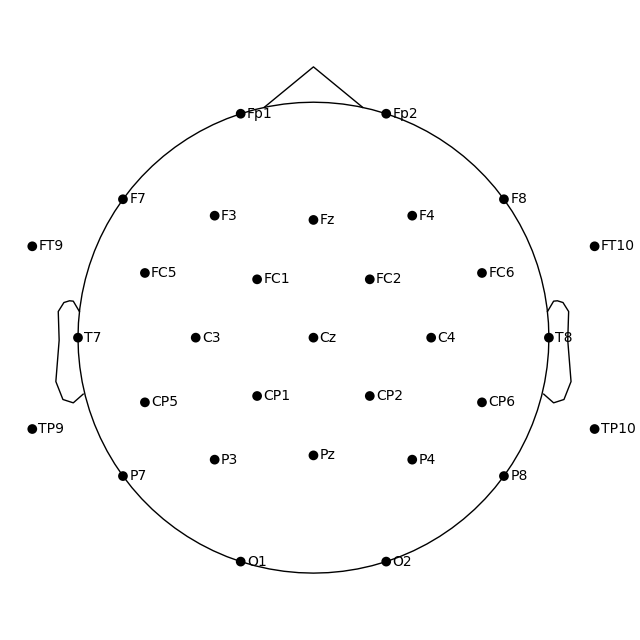

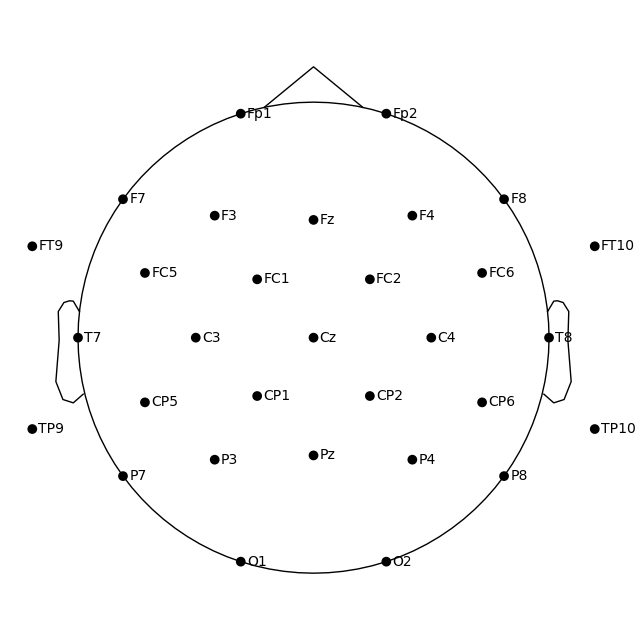

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


In [10]:
##################################
#####          LOAD          #####
##################################
# Get the current working directory
cwd = os.getcwd()

# Assuming the script is run from within the repository
repo = Repo(os.getcwd(), search_parent_directories=True)
repo_root = repo.git.rev_parse("--show-toplevel")

# Define the file path components for Campeones Analysis project
raw_data_folder = "data/raw"

subject = "16"
session = "vr"
task = "02"
acquisition = "b"
run = "008"
data = "eeg"

# Create a BIDSPath object pointing to raw data
bids_path = BIDSPath(
    subject=subject,
    session=session,
    task=task,
    acquisition=acquisition,
    run=run,
    datatype=data,
    suffix=data,
    extension=".vhdr",  # Using .vhdr as the main file for BrainVision format
    root=os.path.join(repo_root, raw_data_folder),
)

##################################
#####      FOR SAVING        #####
##################################
# Defining the paths for saving results to derivatives folder
derivatives_folder = os.path.join(repo_root, "data", "derivatives")
bids_dir = os.path.join(derivatives_folder, f"sub-{subject}", f"ses-{session}", "eeg")
os.makedirs(bids_dir, exist_ok=True)

# Initialize a report to document the preprocessing steps
report = mne.Report(
    title=f"Preprocessing sub-{subject} ses-{session} task-{task} run-{run}"
)

# Path to the JSON file where preprocessing details will be stored
json_path = os.path.join(
    derivatives_folder, "logs_preprocessing_details_all_subjects_eeg.json"
)

# Initialize the logging class
log_preprocessing = LogPreprocessingDetails(json_path, subject, session, f"{task}_run-{run}")


##################################
########   1.READ RAW   ##########
##################################

# Read Raw bids - BrainVision format (.vhdr, .vmrk, .eeg)
raw = read_raw_bids(bids_path)

# Initialize bad channels list (can be populated based on visual inspection)
# For now, start with empty list - you can update this manually if needed
raw.info["bads"] = []

print(f"Loading file: {bids_path}")
print(raw.info)

# Plot sensor location in the scalp
sensor_fig = raw.plot_sensors(show_names=True)
plt.show()

# Add the raw data info to the report
report.add_raw(raw=raw, title="Raw", psd=True)

# Log the raw data info
log_preprocessing.log_detail("info", str(raw.info))

Backend de matplotlib actual: widget
Creando navegador interactivo de datos...


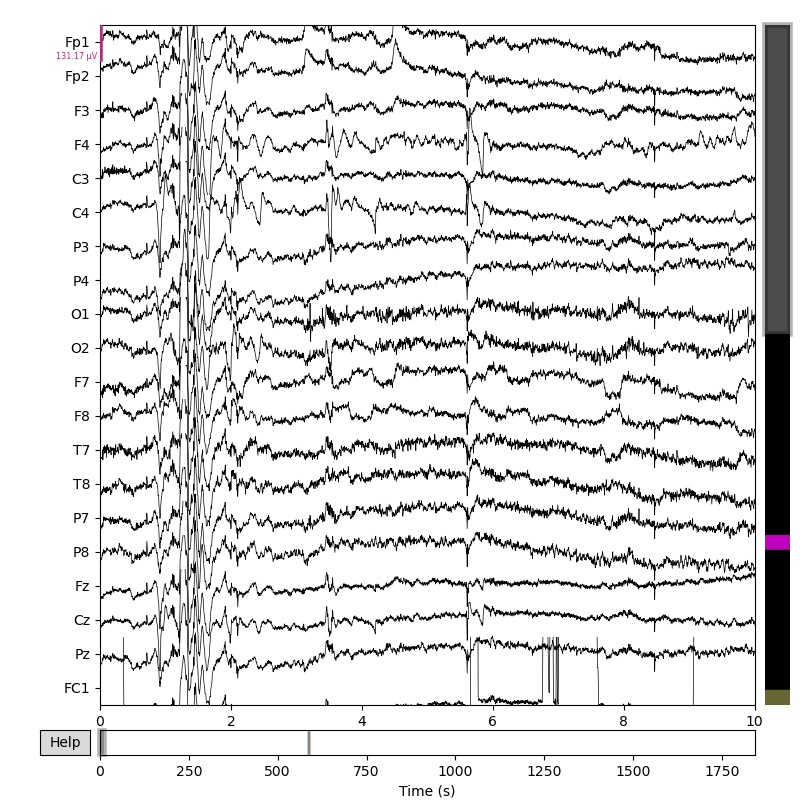

Navegador creado. Si no ves el widget, verifica que ipympl esté funcionando correctamente.
Datos cargados: 460751 puntos temporales, 250.0 Hz
Canales: 44 total (44 nombres)
Duración: 1843.00 segundos


In [12]:
# Verificar backend y crear navegador interactivo de datos
print(f"Backend de matplotlib actual: {matplotlib.get_backend()}")

# Crear navegador interactivo de datos EEG
print("Creando navegador interactivo de datos...")
browser = raw.plot(block=False, scalings="auto")
print("Navegador creado. Si no ves el widget, verifica que ipympl esté funcionando correctamente.")

# También podemos verificar la calidad de las señales
print(f"Datos cargados: {raw.n_times} puntos temporales, {raw.info['sfreq']} Hz")
print(f"Canales: {raw.info['nchan']} total ({len(raw.info['ch_names'])} nombres)")
print(f"Duración: {raw.times[-1]:.2f} segundos")


# 2.FILTERING

In [14]:
# Apply a band-pass filter to keep frequencies between 1 and 45 Hz
hpass = 1.0
lpass = 64
raw_filtered = raw.load_data().copy().notch_filter(np.arange(50, 150, 50)).filter(l_freq=hpass, h_freq=lpass)

# Save the filtered data
# bids_path.update(root = derivatives_folder, description = 'filtered')
# write_raw_bids(raw_filtered, bids_path, format='BrainVision', allow_preload=True, overwrite=True)

# Log the filter settings
log_preprocessing.log_detail("hpass_filter", hpass)
log_preprocessing.log_detail("lpass_filter", lpass)
log_preprocessing.log_detail("filter_type", "bandpass")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 64 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 64.00 Hz
- Upper transition bandwidth: 16.00 Hz (-6 dB cutoff frequency: 72.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.4s finished


# 3.Visual inspection of CHs

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


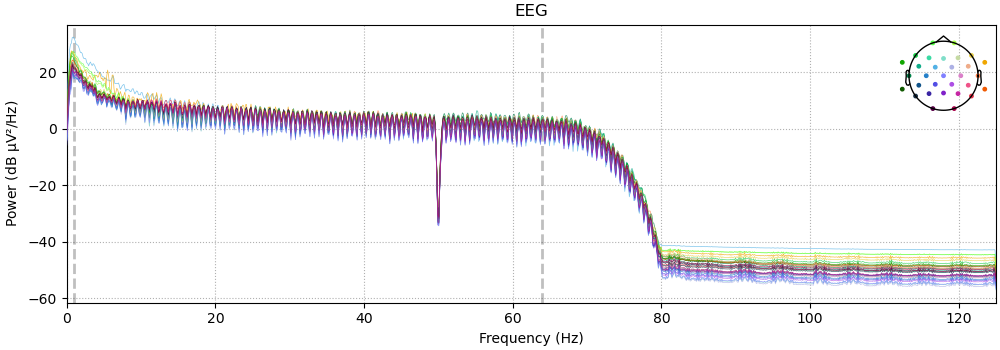

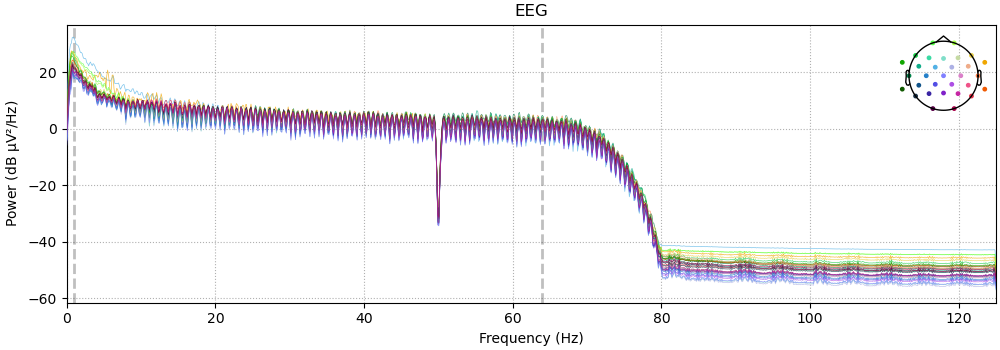

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 8
Total # of chunks: 4
Current chunk:
1
2
3
4

RANSAC done!
Bad channels detected: ['FC1']


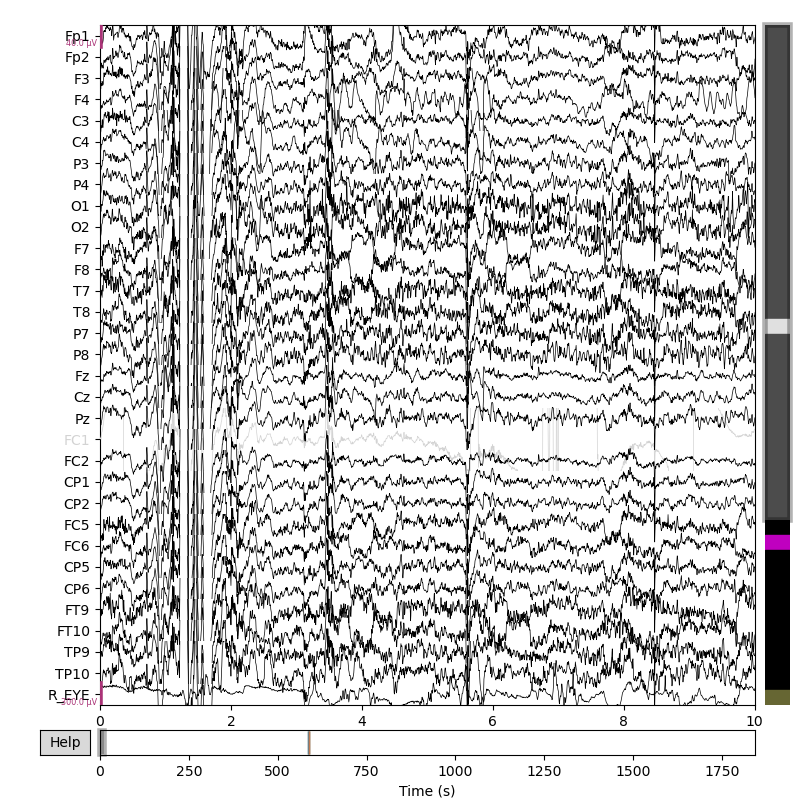

Navegador de datos filtrados creado. Úsalo para identificar visualmente canales malos.
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


2025-06-26 00:55:55,100 - Comm - WARNING - No such comm: 4fee0cfca595481297e4c402a6bea3b9
2025-06-26 00:55:55,100 - Comm - WARNING - No such comm: 4fee0cfca595481297e4c402a6bea3b9
2025-06-26 00:55:55,115 - Comm - WARNING - No such comm: 4fee0cfca595481297e4c402a6bea3b9
2025-06-26 00:55:55,115 - Comm - WARNING - No such comm: 4fee0cfca595481297e4c402a6bea3b9


In [ ]:
# Plots PSD of the raw data
psd_fig = raw_filtered.compute_psd().plot()
plt.show()

#automatically mark bad channels
nd = NoisyChannels(raw_filtered,do_detrend = False, random_state=42)
nd.find_all_bads(ransac=True, channel_wise=True) #if it slows down, set channel_wise to False
bads = nd.get_bads()
print(f"Bad channels detected: {bads}")
if bads != None:
    raw_filtered.info["bads"] = bads

# Plot the filtered data for visual inspection to identify bad channels
filtered_browser = raw_filtered.plot(n_channels=32, block=False)
print("Navegador de datos filtrados creado. Úsalo para identificar visualmente canales malos.")

# Add the filtered data to the report
report.add_raw(raw=raw_filtered, title="Filtered Raw", psd=True)

# Log the identified bad channels
log_preprocessing.log_detail("bad_channels", raw_filtered.info["bads"])

# 4. EPOCHING

In [16]:
##################################
######    LOAD TRIGGGERS   #######
##################################
# Load events from merged_events (with variable durations and real onset times)
events_file = os.path.join(
    derivatives_folder, "merged_events", f"sub-{subject}", f"ses-{session}", "eeg",
    f"sub-{subject}_ses-{session}_task-{task}_acq-{acquisition}_run-{run}_desc-merged_events.tsv"
)

# Load events from TSV file
print(f"Loading events from: {events_file}")
events_df = pd.read_csv(events_file, sep='\t')
print(f"Events loaded: {len(events_df)} events")
print(f"Event types found: {events_df['trial_type'].unique()}")
print(f"Conditions found: {events_df['condition'].unique()}")

# Verify that the onset times are reasonable
print(f"Onset times: min={events_df['onset'].min():.1f}s, max={events_df['onset'].max():.1f}s")
print(f"Durations: min={events_df['duration'].min():.1f}s, max={events_df['duration'].max():.1f}s")

# Convert events to MNE annotations
annotations = mne.Annotations(
    onset=events_df['onset'].values,
    duration=events_df['duration'].values,
    description=events_df['trial_type'].values
)

# Add annotations to raw data
raw_filtered.set_annotations(annotations)
print(f"Annotations added: {len(raw_filtered.annotations)}")

##################################
####### VARIABLE DURATION EPOCHS #######
##################################
# Create epochs with variable duration based on events
# Each event can have different duration, so we create individual epochs

epochs_list = []
epochs_metadata = []

print(f"Creating variable duration epochs for {len(events_df)} events...")

for idx, row in events_df.iterrows():
    onset_time = float(row['onset'])
    duration = float(row['duration'])
    trial_type = str(row['trial_type'])
    
    # Create epoch with pre-stimulus period for baseline correction
    tmin = -0.3  # 300ms before event for baseline
    tmax = duration  # Full duration of the event
    
    # Find onset in samples
    onset_sample = int(onset_time * raw_filtered.info['sfreq'])
    
    # Create temporary event for this epoch
    temp_event = np.array([[onset_sample, 0, 1]])  # [sample, prev_id, event_id]
    temp_event_id = {trial_type: 1}
    
    try:
        # Create epoch for this individual event
        temp_epochs = mne.Epochs(
            raw_filtered,
            events=temp_event,
            event_id=temp_event_id,
            tmin=tmin,
            tmax=tmax,
            preload=True,  # Load in memory to verify length
            verbose=False,
            baseline=None  # Don't apply baseline yet
        )
        
        if len(temp_epochs.events) > 0:  # Verify epoch is valid
            epochs_list.append(temp_epochs)
            epochs_metadata.append({
                'trial_type': trial_type,
                'onset': onset_time,
                'duration': duration,
                'epoch_idx': idx
            })
            
    except Exception as e:
        print(f"Error creating epoch for event {idx} ({trial_type}): {e}")
        continue

print(f"Successfully created epochs: {len(epochs_list)}")
print(f"Event types processed: {set([meta['trial_type'] for meta in epochs_metadata])}")

# For compatibility with existing code, use first epoch as reference
if epochs_list:
    epochs = epochs_list[0]  # For backward compatibility
    
    # Log information about variable epochs
    durations = [meta['duration'] for meta in epochs_metadata]
    print(f"Duration range: {min(durations):.2f}s - {max(durations):.2f}s (mean: {np.mean(durations):.2f}s)")
    
else:
    print("No valid epochs could be created")
    epochs = None

# Save the epoched data
# bids_compliance.save_epoched_bids(epochs, derivatives_folder, subject, session,
#                                   task, data, desc = 'epoched', events = events, event_id =event_id)

# Add the epochs to the report (using first epoch as example)
if epochs is not None:
    report.add_epochs(epochs=epochs, title="Variable Duration Epochs (first example)")
    
    # Log details about variable duration epochs
    log_preprocessing.log_detail("n_epochs_variable_duration", len(epochs_list))
    log_preprocessing.log_detail("min_duration", min(durations))
    log_preprocessing.log_detail("max_duration", max(durations))
    log_preprocessing.log_detail("mean_duration", np.mean(durations))
    log_preprocessing.log_detail("epochs_metadata", epochs_metadata)
    log_preprocessing.log_detail("baseline_period", "(-0.3, 0)")
    
    print(f"Logged {len(epochs_list)} variable duration epochs")
else:
    print("Warning: No epochs available for logging")

Loading events from: C:/Users/tdamelio/Desktop/campeones_analysis\data\derivatives\merged_events\sub-16\ses-vr\eeg\sub-16_ses-vr_task-02_acq-b_run-008_desc-merged_events.tsv
Events loaded: 4 events
Event types found: ['video' 'video_luminance']
Conditions found: ['affective' 'luminance']
Onset times: min=626.6s, max=1675.9s
Durations: min=60.0s, max=216.0s
Annotations added: 4
Creating variable duration epochs for 4 events...
Successfully created epochs: 4
Event types processed: {'video_luminance', 'video'}
Duration range: 60.01s - 216.04s (mean: 138.53s)
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Logged 4 variable duration epochs


# 5. Reject Bad Epochs 1

In [17]:
# Automatic rejection adapted for variable duration epochs
if epochs_list and len(epochs_list) > 0:
    print("Applying automatic rejection to variable duration epochs...")
    
    # Process each epoch individually
    epochs_clean_list = []
    all_reject_logs = []
    
    for i, temp_epochs in enumerate(epochs_list):
        trial_type = epochs_metadata[i]['trial_type']
        duration = epochs_metadata[i]['duration']
        
        try:
            # Apply AutoReject only if epoch has sufficient duration
            if duration > 0.5:  # Only apply if duration > 0.5s
                # Use more conservative parameters for individual epochs
                ar = AutoReject(
                    thresh_method="random_search",  # Faster for individual epochs
                    cv=3,  # Fewer folds for individual epochs
                    random_state=42,
                    n_jobs=1
                )
                temp_epochs_clean = ar.fit_transform(temp_epochs)
            else:
                # For very short events, only apply basic threshold
                reject_criteria = get_rejection_threshold(temp_epochs)
                temp_epochs_clean = temp_epochs.copy()
                temp_epochs_clean.drop_bad(reject=reject_criteria)
            
            epochs_clean_list.append(temp_epochs_clean)
            # Log rejection for individual epochs
            if hasattr(temp_epochs_clean, 'drop_log') and temp_epochs_clean.drop_log is not None:
                all_reject_logs.append(temp_epochs_clean.drop_log)
            else:
                all_reject_logs.append([])
            
            print(f"Epoch {i} ({trial_type}, {duration:.2f}s): {len(temp_epochs_clean)} valid epochs")
            
        except Exception as e:
            print(f"Error processing epoch {i} ({trial_type}): {e}")
            # If error, keep original epoch
            epochs_clean_list.append(temp_epochs)
            all_reject_logs.append([])
    
    # For compatibility with existing code, use first clean epoch
    if epochs_clean_list:
        epochs_clean = epochs_clean_list[0]
        
        # Calculate rejection statistics
        total_original = len(epochs_list)
        total_clean = len(epochs_clean_list)
        
        print(f"Epochs processed: {total_original}")
        print(f"Valid epochs after cleaning: {total_clean}")
        
        # Log statistics
        log_preprocessing.log_detail("epochs_clean_variable_duration", len(epochs_clean_list))
        log_preprocessing.log_detail("epochs_original_count", total_original)
        log_preprocessing.log_detail("epochs_processing_success_rate", total_clean/total_original if total_original > 0 else 0)
        
    else:
        print("Error: Could not process epochs")
        epochs_clean = None
        
else:
    print("Error: No epochs to process")
    epochs_clean = None
    epochs_clean_list = []

Applying automatic rejection to variable duration epochs...
Running autoreject on ch_type=eeg


c:\micromamba\envs\campeones\Lib\site-packages\autoreject\utils.py:73: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

Error processing epoch 0 (video): The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Running autoreject on ch_type=eeg


c:\micromamba\envs\campeones\Lib\site-packages\autoreject\utils.py:73: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

Error processing epoch 1 (video): The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Running autoreject on ch_type=eeg


c:\micromamba\envs\campeones\Lib\site-packages\autoreject\utils.py:73: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

Error processing epoch 2 (video): The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Running autoreject on ch_type=eeg


c:\micromamba\envs\campeones\Lib\site-packages\autoreject\utils.py:73: UserWarning: 1 channels are marked as bad. These will be ignored. If you want them to be considered by autoreject please remove them from epochs.info["bads"].
  warnings.warn(


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

Error processing epoch 3 (video_luminance): The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Epochs processed: 4
Valid epochs after cleaning: 4


Manual inspection of variable duration epochs...
Plotting first epoch for manual inspection...
NOTE: Close the plot window to continue


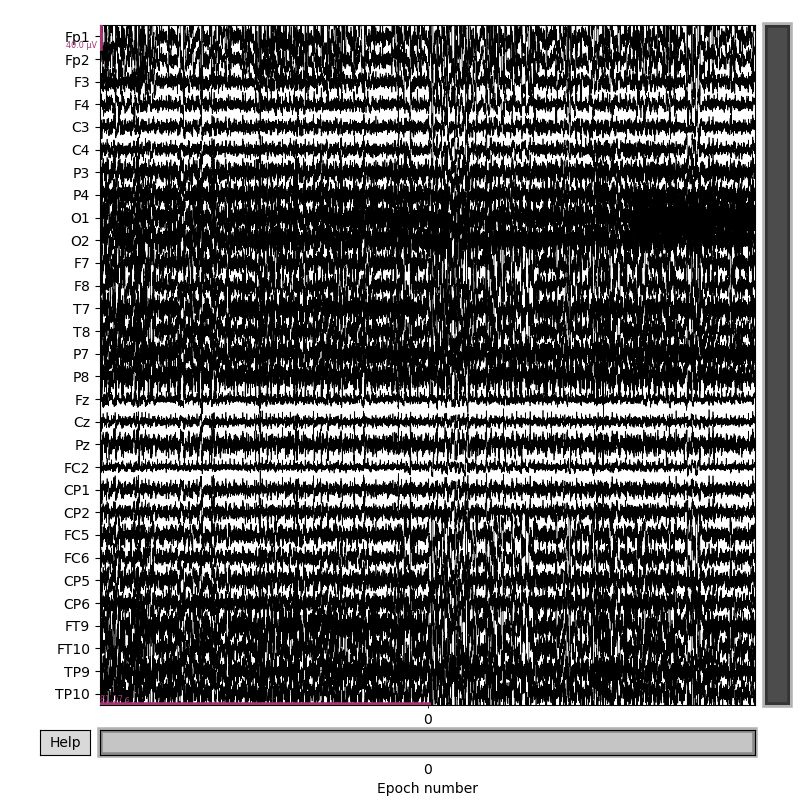

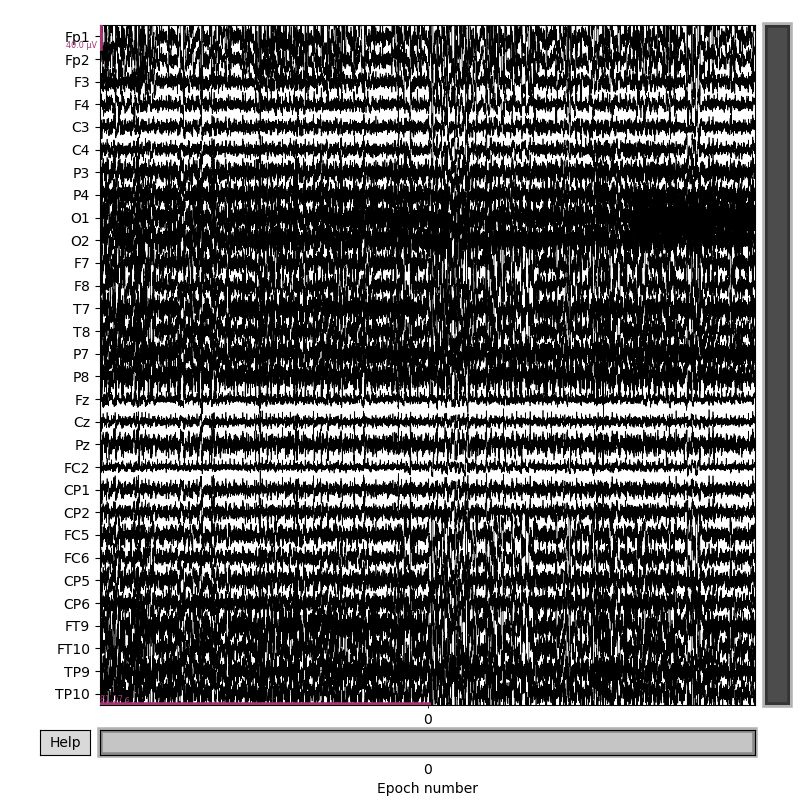

Manually rejected epochs: []
Variable duration epochs processing: 4/4 (100.0%)
Processing completed for 4 variable duration epochs


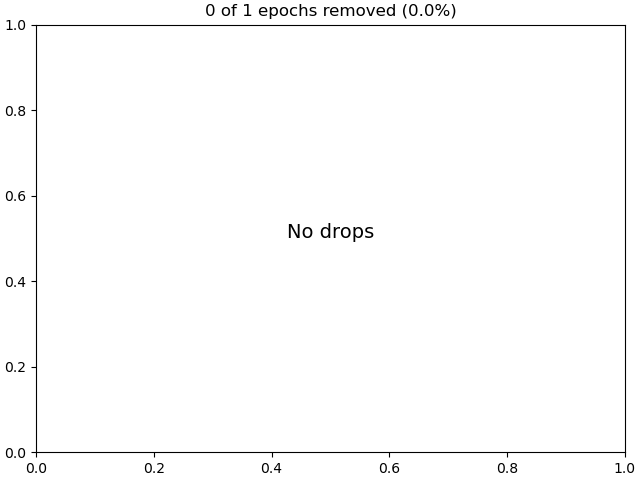

In [18]:
# Manual inspection adapted for variable duration epochs
if epochs_clean is not None and epochs_clean_list:
    print("Manual inspection of variable duration epochs...")
    
    # Plot the first epoch for manual inspection
    if len(epochs_clean) > 0:
        print("Plotting first epoch for manual inspection...")
        print("NOTE: Close the plot window to continue")
        epochs_clean.plot(n_channels=32)
        plt.show(block=True)
    
    # Calculate manual rejection statistics
    manual_reject_epochs = [
        n_epoch for n_epoch, log in enumerate(epochs_clean.drop_log) if log == ("USER",)
    ]
    print(f"Manually rejected epochs: {manual_reject_epochs}")
    
    # Calculate total rejection rate for variable duration epochs
    total_processed = len(epochs_clean_list)
    total_original = len(epochs_list) if epochs_list else 0
    success_rate = total_processed / total_original * 100 if total_original > 0 else 0
    
    print(f"Variable duration epochs processing: {total_processed}/{total_original} ({success_rate:.1f}%)")
    
    # Log manual rejection details
    log_preprocessing.log_detail("manual_reject_epochs_variable", manual_reject_epochs)
    log_preprocessing.log_detail("len_manual_reject_epochs", len(manual_reject_epochs))
    log_preprocessing.log_detail("variable_epochs_success_rate", success_rate)
    
    # Plot drop log for the first epoch
    if hasattr(epochs_clean, 'plot_drop_log'):
        epochs_clean.plot_drop_log()
    
    # Add the cleaned epochs to the report
    report.add_epochs(epochs=epochs_clean, title="Variable Duration Epochs - Clean (first example)", psd=False)
    
    # Drop bad epochs for all epochs in the list
    for temp_epochs_clean in epochs_clean_list:
        temp_epochs_clean.drop_bad()
    
    print(f"Processing completed for {len(epochs_clean_list)} variable duration epochs")
    
else:
    print("Error: No clean epochs available for manual inspection")
    epochs_clean_list = []

# 6. Independent Component Analysis (ICA)

Applying ICA to variable duration epochs...
Training ICA on filtered raw data...
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 30.9s.
Using EOG channel: R_EYE
Using threshold: 0.32 for CTPS ECG detection
    Using multitaper spectrum estimation with 7 DPSS windows
EOG components detected: []
ECG components detected: [np.int64(14), np.int64(13), np.int64(12), np.int64(11), np.int64(10), np.int64(9), np.int64(8), np.int64(7), np.int64(6), np.int64(5), np.int64(4), np.int64(3), np.int64(2), np.int64(1), np.int64(0)]
Muscle components detected: [5, 6, 9, 11, 12, 14]


C:\Users\tdamelio\AppData\Local\Temp\ipykernel_13748\839013146.py:48: RuntimeWarning: The provided Epochs instance does not seem to be referenced to a common average reference (CAR). ICLabel was designed to classify features extracted from an EEG dataset referenced to a CAR (see the 'set_eeg_reference()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs_clean, ica, method="iclabel")
C:\Users\tdamelio\AppData\Local\Temp\ipykernel_13748\839013146.py:48: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs_clean, ica, method="iclabel")
C:\Users\tdamelio\AppData\Local\Temp\ipykernel_13748\839013146.py:48: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA d

Classification of all ICA components. Results:
['other', 'eye blink', 'eye blink', 'brain', 'brain', 'brain', 'muscle artifact', 'brain', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'brain', 'muscle artifact']
ICA components to exclude: [1, 2, 6, 9, 11, 14]
Plotting ICA components...
NOTE: Close the plot window to continue
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


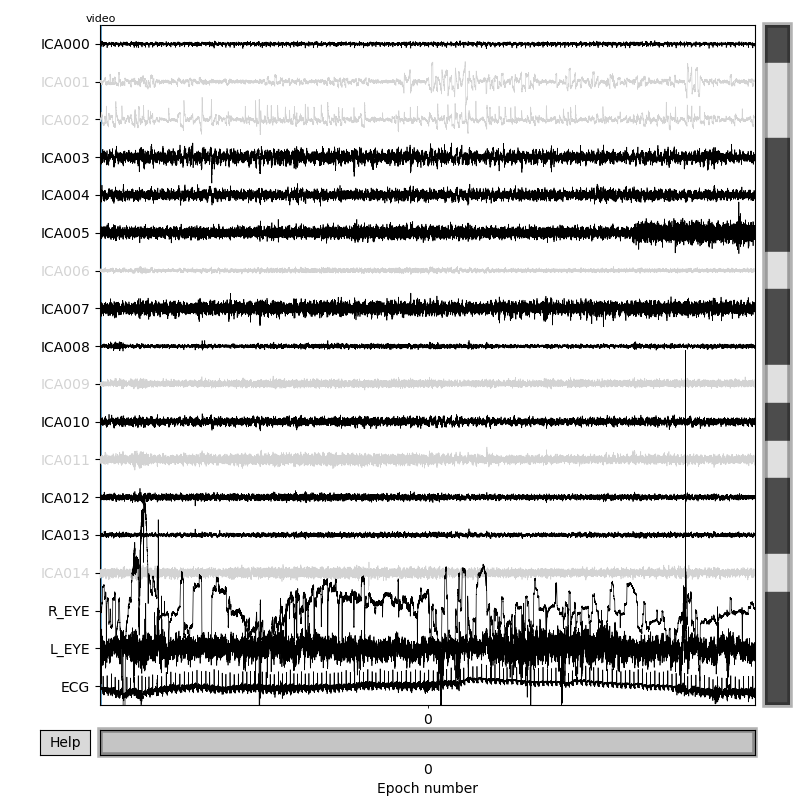

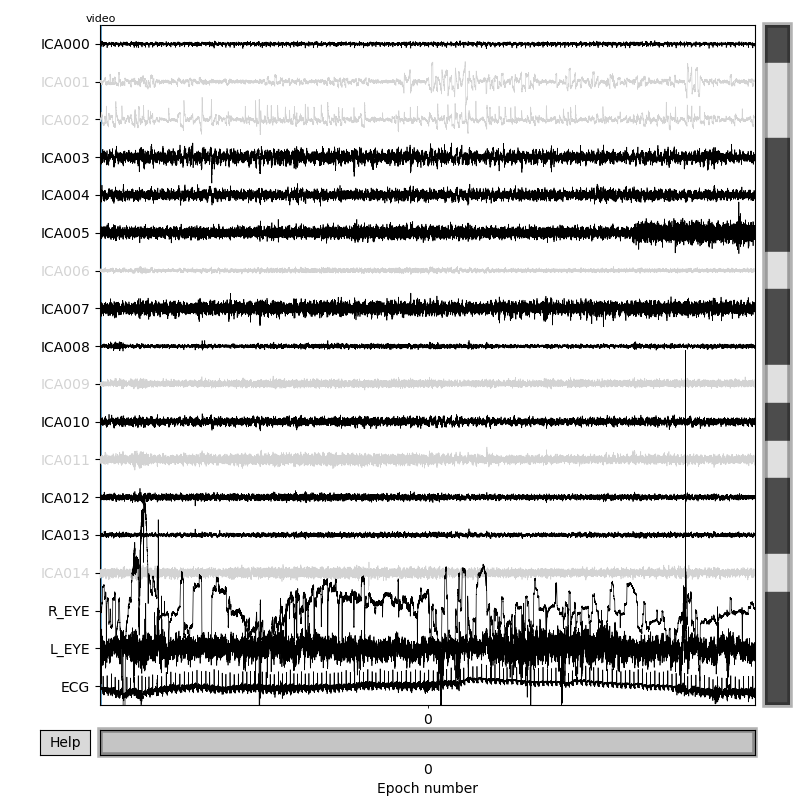

Applying ICA to Evoked instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Projecting back using 30 PCA components
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=1)]: Done   0 out of   1 | elapsed:    0.9s remaining:    0.9s


ValueError: `dataset` input should have multiple elements.

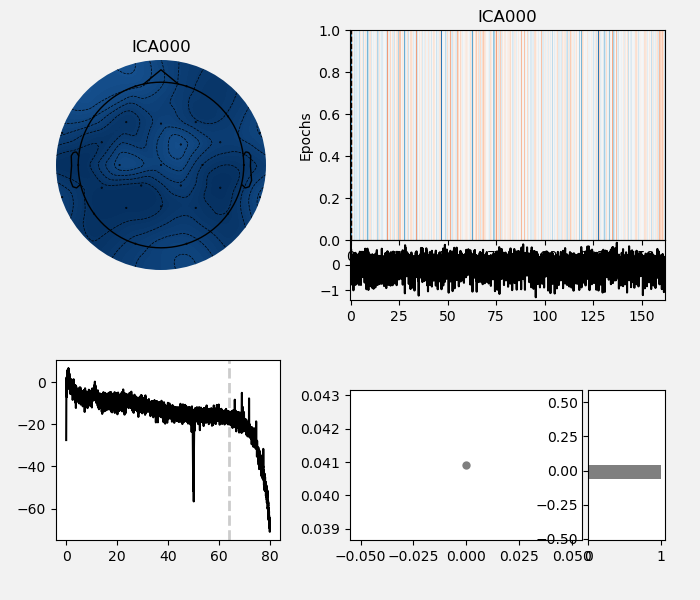

In [19]:
# ICA adapted for variable duration epochs
if epochs_clean is not None and epochs_clean_list:
    print("Applying ICA to variable duration epochs...")
    
    # Parameters for ICA
    n_components = 15
    method = "picard"
    max_iter = "auto"
    random_state = 42
    
    # Initialize the ICA object
    ica = mne.preprocessing.ICA(
        n_components=n_components,
        method=method,
        max_iter=max_iter,
        random_state=random_state,
    )
    
    # Train ICA on raw_filtered data for stability (more stable than variable epochs)
    print("Training ICA on filtered raw data...")
    ica.fit(raw_filtered)
    
    # Detect artifact components using epochs_clean as reference
    try:
        eog_components, _ = ica.find_bads_eog(inst=epochs_clean, ch_name="R_EYE")
    except:
        eog_components = []
        print("Could not detect EOG components")
        
    try:
        ecg_components, _ = ica.find_bads_ecg(inst=epochs_clean, ch_name="ECG")
    except:
        ecg_components = []
        print("Could not detect ECG components")
        
    try:
        muscle_components, _ = ica.find_bads_muscle(epochs_clean, threshold=0.7)
    except:
        muscle_components = []
        print("Could not detect muscle components")
        
    print(f"EOG components detected: {eog_components}")
    print(f"ECG components detected: {ecg_components}")
    print(f"Muscle components detected: {muscle_components}")
    
    # Automatic classification with ICLabel
    try:
        ic_labels = label_components(epochs_clean, ica, method="iclabel")
        print("Classification of all ICA components. Results:")
        print(ic_labels["labels"])
        label_names = ic_labels["labels"]
    except Exception as e:
        print(f"Error in ICLabel classification: {e}")
        label_names = ["unknown"] * n_components
    
    # Determine components to exclude
    pattern_matching_artifacts = np.unique(
        ecg_components + eog_components + muscle_components
    )
    
    channel_artifact_indices = [
        i for i, label in enumerate(label_names) if label == "channel noise"
    ]
    
    # Find components that match between pattern matching and ICLabel
    to_exclude = []
    for idx in pattern_matching_artifacts:
        if idx < len(label_names) and label_names[idx] in [
            "muscle artifact", "eye blink", "heart beat", "channel noise"
        ]:
            to_exclude.append(idx)
            
    if len(eog_components) > 0 and eog_components[0] < 3:
        to_exclude.append(eog_components[0])
        
    to_exclude = np.unique(to_exclude + channel_artifact_indices)
    ica.exclude = to_exclude.tolist()
    
    print(f"ICA components to exclude: {ica.exclude}")
    
    # Plot ICA sources for visual inspection
    print("Plotting ICA components...")
    print("NOTE: Close the plot window to continue")
    ica.plot_sources(epochs_clean, block=True, show=True)
    plt.show(block=True)
    report.add_ica(ica, title="ICA", inst=epochs_clean)
    
    # Apply ICA to all variable duration epochs
    epochs_ica_list = []
    for i, temp_epochs_clean in enumerate(epochs_clean_list):
        try:
            temp_epochs_ica = ica.apply(inst=temp_epochs_clean)
            epochs_ica_list.append(temp_epochs_ica)
        except Exception as e:
            print(f"Error applying ICA to epoch {i}: {e}")
            epochs_ica_list.append(temp_epochs_clean)  # Keep without ICA if error
    
    # For compatibility, use first epoch with ICA applied
    epochs_ica = epochs_ica_list[0] if epochs_ica_list else epochs_clean
    
    # Log ICA details
    log_preprocessing.log_detail("ica_components", ica.exclude)
    log_preprocessing.log_detail("ica_method", method)
    log_preprocessing.log_detail("ica_max_iter", max_iter)
    log_preprocessing.log_detail("ica_random_state", random_state)
    log_preprocessing.log_detail("ica_applied_to_variable_epochs", len(epochs_ica_list))
    
else:
    print("Error: No clean epochs available for ICA")
    epochs_ica = None
    epochs_ica_list = []

In [9]:
# Final cleaning adapted for variable duration epochs
if epochs_ica is not None and epochs_ica_list:
    print("Applying final cleaning to variable duration epochs...")
    
    # Process each epoch individually for final cleaning
    epochs_final_list = []
    
    for i, temp_epochs_ica in enumerate(epochs_ica_list):
        trial_type = epochs_metadata[i]['trial_type']
        duration = epochs_metadata[i]['duration']
        
        # Clone epochs for final cleaning
        temp_epochs_final = temp_epochs_ica.copy()
        
        # Apply baseline using pre-stimulus period
        try:
            # Use pre-stimulus period (-0.3 to 0) as baseline
            baseline = (-0.3, 0)
            temp_epochs_final.apply_baseline(baseline)
            print(f"Baseline applied to epoch {i} ({trial_type}): {baseline}")
        except Exception as e:
            print(f"Could not apply baseline to epoch {i}: {e}")
            # If fails, try shorter baseline
            try:
                baseline = (-0.1, 0)
                temp_epochs_final.apply_baseline(baseline)
                print(f"Alternative baseline applied to epoch {i}: {baseline}")
            except:
                print(f"Could not apply any baseline to epoch {i}")
        
        epochs_final_list.append(temp_epochs_final)
        print(f"Final epoch {i}: {trial_type}, duration: {duration:.2f}s, samples: {len(temp_epochs_final)}")
    
    # For compatibility, use first final epoch
    epochs_ica = epochs_final_list[0] if epochs_final_list else epochs_ica
    
    # Plot first epoch for inspection
    if len(epochs_ica) > 0:
        print("Plotting epochs after ICA...")
        print("NOTE: Close the plot window to continue")
        epochs_ica.plot(n_channels=32)
        plt.show(block=True)
    
    # Calculate final statistics
    total_processed = len(epochs_final_list)
    total_original = len(epochs_list) if epochs_list else 0
    success_rate = total_processed / total_original * 100 if total_original > 0 else 0
    
    print(f"Epochs processed successfully: {total_processed}/{total_original} ({success_rate:.1f}%)")
    
    # Log final statistics
    log_preprocessing.log_detail("epochs_final_count", total_processed)
    log_preprocessing.log_detail("epochs_success_rate", success_rate)
    log_preprocessing.log_detail("baseline_period", "(-0.3, 0)")
    log_preprocessing.log_detail("baseline_applied_to_variable_epochs", True)
    log_preprocessing.log_detail("epochs_final_metadata", epochs_metadata)
    
    # Manual inspection after ICA
    manual_reject_epochs_after_ica = [
        n_epoch for n_epoch, log in enumerate(epochs_ica.drop_log) if log == ("USER",)
    ]
    print(f"Manually rejected epochs after ICA: {manual_reject_epochs_after_ica}")
    
    log_preprocessing.log_detail("manual_reject_epochs_after_ica", manual_reject_epochs_after_ica)
    log_preprocessing.log_detail("len_manual_reject_epochs_after_ica", len(manual_reject_epochs_after_ica))
    log_preprocessing.log_detail("total_variable_epochs_success_rate", success_rate)
    
else:
    print("Error: No epochs with ICA available for final cleaning")
    epochs_final_list = []

Applying baseline correction (mode: mean)
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Manually rejected epochs after ICA: []
Total epochs rejected: 35.256410256410255%


# 7. Interpolate Chs and Rereference

In [8]:
# Rereferencing and interpolation adapted for variable duration epochs
if epochs_final_list:
    print("Applying rereferencing and interpolation to variable duration epochs...")
    
    # Apply rereferencing and interpolation to all individual epochs
    epochs_interpolated_list = []
    
    for i, temp_epochs_final in enumerate(epochs_final_list):
        trial_type = epochs_metadata[i]['trial_type']
        duration = epochs_metadata[i]['duration']
        
        try:
            # Load data in memory if not loaded
            temp_epochs_copy = temp_epochs_final.copy().load_data()
            
            # Add reference channel FCz
            temp_epochs_ref = mne.add_reference_channels(temp_epochs_copy, ref_channels=["FCz"])
            
            # Apply montage
            bvef_file_path = os.path.join(repo_root, "BC-32_FCz_modified.bvef")
            if os.path.exists(bvef_file_path):
                montage = mne.channels.read_custom_montage(bvef_file_path)
                temp_epochs_ref.set_montage(montage)
            else:
                print(f"Warning: Montage file not found: {bvef_file_path}")
            
            # Rereference to average
            temp_epochs_rereferenced, _ = mne.set_eeg_reference(
                inst=temp_epochs_ref, ref_channels="average", copy=True
            )
            
            # Interpolate bad channels
            temp_epochs_interpolated = temp_epochs_rereferenced.copy().interpolate_bads()
            
            epochs_interpolated_list.append(temp_epochs_interpolated)
            
            print(f"Epoch {i} ({trial_type}, {duration:.2f}s): rereferencing and interpolation successful")
            
        except Exception as e:
            print(f"Error in rereferencing/interpolation for epoch {i}: {e}")
            # Keep original epoch if error
            epochs_interpolated_list.append(temp_epochs_final)
    
    # For compatibility with existing code
    if epochs_interpolated_list:
        epochs_interpolate = epochs_interpolated_list[0]
        
        # Add to report using first example
        report.add_epochs(
            epochs=epochs_interpolate, 
            title="Variable Duration Epochs - Interpolated and Rereferenced (first example)", 
            psd=True
        )
        
        print(f"Complete processing: {len(epochs_interpolated_list)} final epochs")
        
        # Log rereferencing details
        log_preprocessing.log_detail("rereferenced_channels", "grand_average")
        log_preprocessing.log_detail("interpolated_channels", epochs_interpolate.info["bads"])
        log_preprocessing.log_detail("final_epochs_count", len(epochs_interpolated_list))
        
    else:
        print("Error: Could not process epochs for rereferencing")
        epochs_interpolate = None
        epochs_interpolated_list = []
        
else:
    print("Error: No final epochs available for rereferencing and interpolation")
    epochs_interpolate = None
    epochs_interpolated_list = []

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


C:\Users\nicolas.bruno\AppData\Local\Temp\ipykernel_28240\1020177285.py:4: RuntimeWarning: The locations of multiple reference channels are ignored.
  epochs_ica = mne.add_reference_channels(epochs_ica.load_data(), ref_channels=["FCz"])
C:\Users\nicolas.bruno\AppData\Local\Temp\ipykernel_28240\1020177285.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs_ica.set_montage(montage)


    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 31 sensor positions
Interpolating 1 sensors


# SAVE Preprocessed data 

In [13]:
# Save variable duration epochs
if epochs_interpolated_list and epochs_interpolate is not None:
    print("Saving variable duration epochs...")
    
    # Save each epoch individually with specific metadata
    for i, temp_epochs_interpolated in enumerate(epochs_interpolated_list):
        trial_type = epochs_metadata[i]['trial_type']
        duration = epochs_metadata[i]['duration']
        
        try:
            # Create specific description for this epoch
            desc = f"preproc-{trial_type}-dur{duration:.1f}s"
            
            # Create specific events for this epoch
            temp_events = np.array([[0, 0, 1]])  # Event at beginning
            temp_event_id = {trial_type: 1}
            
            # Save individual epoch
            bids_compliance.save_epoched_bids(
                temp_epochs_interpolated,
                derivatives_folder,
                subject,
                session,
                task,
                data,
                desc=desc,
                events=temp_events,
                event_id=temp_event_id,
            )
            
            print(f"Epoch {i} saved: {trial_type} (duration: {duration:.2f}s)")
            
        except Exception as e:
            print(f"Error saving epoch {i}: {e}")
    
    # Also save a reference file with the first epoch for compatibility
    try:
        # Create basic events for compatibility
        basic_events = np.array([[0, 0, 1]])
        basic_event_id = {"variable_duration_epochs": 1}
        
        bids_compliance.save_epoched_bids(
            epochs_interpolate,
            derivatives_folder,
            subject,
            session,
            task,
            data,
            desc="preproc-variableDuration",
            events=basic_events,
            event_id=basic_event_id,
        )
        print("Reference file saved: preproc-variableDuration")
        
    except Exception as e:
        print(f"Error saving reference file: {e}")
    
    # Create evoked responses for variable duration epochs
    evoked_list = []
    evoked_titles = []
    
    print("Creating evoked responses for variable duration epochs...")
    
    for i, temp_epochs_interpolated in enumerate(epochs_interpolated_list[:5]):  # Limit to 5
        trial_type = epochs_metadata[i]['trial_type']
        duration = epochs_metadata[i]['duration']
        
        try:
            if len(temp_epochs_interpolated) > 0:
                evoked = temp_epochs_interpolated.average()
                evoked_list.append(evoked)
                evoked_titles.append(f"Evoked {trial_type} ({duration:.1f}s)")
                print(f"Evoked created for {trial_type}")
        except Exception as e:
            print(f"Could not create evoked for {trial_type}: {e}")
    
    # Add evoked responses to report
    if evoked_list:
        report.add_evokeds(evokeds=evoked_list, titles=evoked_titles)
        print(f"Added {len(evoked_list)} evoked responses to report")
    
else:
    print("Error: No interpolated epochs available for saving")

# Save the report as an HTML file
html_report_fname = bids_compliance.make_bids_basename(
    subject=subject,
    session=session,
    task=task,
    acquisition=acquisition,
    run=run,
    suffix=data,
    extension=".html",
    desc="preprocReport-variableDuration",
)
report.save(os.path.join(bids_dir, html_report_fname), overwrite=True)
print(f"Report saved: {html_report_fname}")

# Save the preprocessing details to the JSON file
log_preprocessing.save_preprocessing_details()
print("Preprocessing completed successfully for variable duration epochs")

# Final summary
if epochs_interpolated_list:
    print(f"\n=== FINAL SUMMARY ===")
    print(f"Total epochs processed: {len(epochs_interpolated_list)}")
    print(f"Event types: {set([meta['trial_type'] for meta in epochs_metadata])}")
    durations = [meta['duration'] for meta in epochs_metadata]
    print(f"Average duration: {np.mean(durations):.2f}s (min: {min(durations):.2f}s, max: {max(durations):.2f}s)")
    print(f"Files saved in: {bids_dir}")
    print("=====================")

Overwriting existing file.
Overwriting existing file.


c:\Users\nicolas.bruno\Documents\GitHub\wandering-mind\Analysis\preprocessing\utils\bids_compliance.py:136: RuntimeWarning: This filename (C:/Users/nicolas.bruno/Documents/GitHub/wandering-mind\derivatives\sub-11\ses-a\eeg\sub-11_ses-a_task-sartauditiva_desc-preproc_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epoched_data.save(bids_path, overwrite=True)


Events saved at: C:/Users/nicolas.bruno/Documents/GitHub/wandering-mind\derivatives\sub-11\ses-a\eeg\sub-11_ses-a_task-sartauditiva_desc-preproc_events.tsv
Events metadata saved at: C:/Users/nicolas.bruno/Documents/GitHub/wandering-mind\derivatives\sub-11\ses-a\eeg\sub-11_ses-a_task-sartauditiva_desc-preproc_events.json
Epoch object metadata saved at: C:/Users/nicolas.bruno/Documents/GitHub/wandering-mind\derivatives\sub-11\ses-a\eeg\sub-11_ses-a_task-sartauditiva_desc-preproc_eeg.json


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Overwriting existing file.
Saving report to : C:\Users\nicolas.bruno\Documents\GitHub\wandering-mind\derivatives\sub-11\ses-a\eeg\sub-11_ses-a_task-sartauditiva_desc-preprocReport_eeg.html


Optional: Observe Preprocessed Data 

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


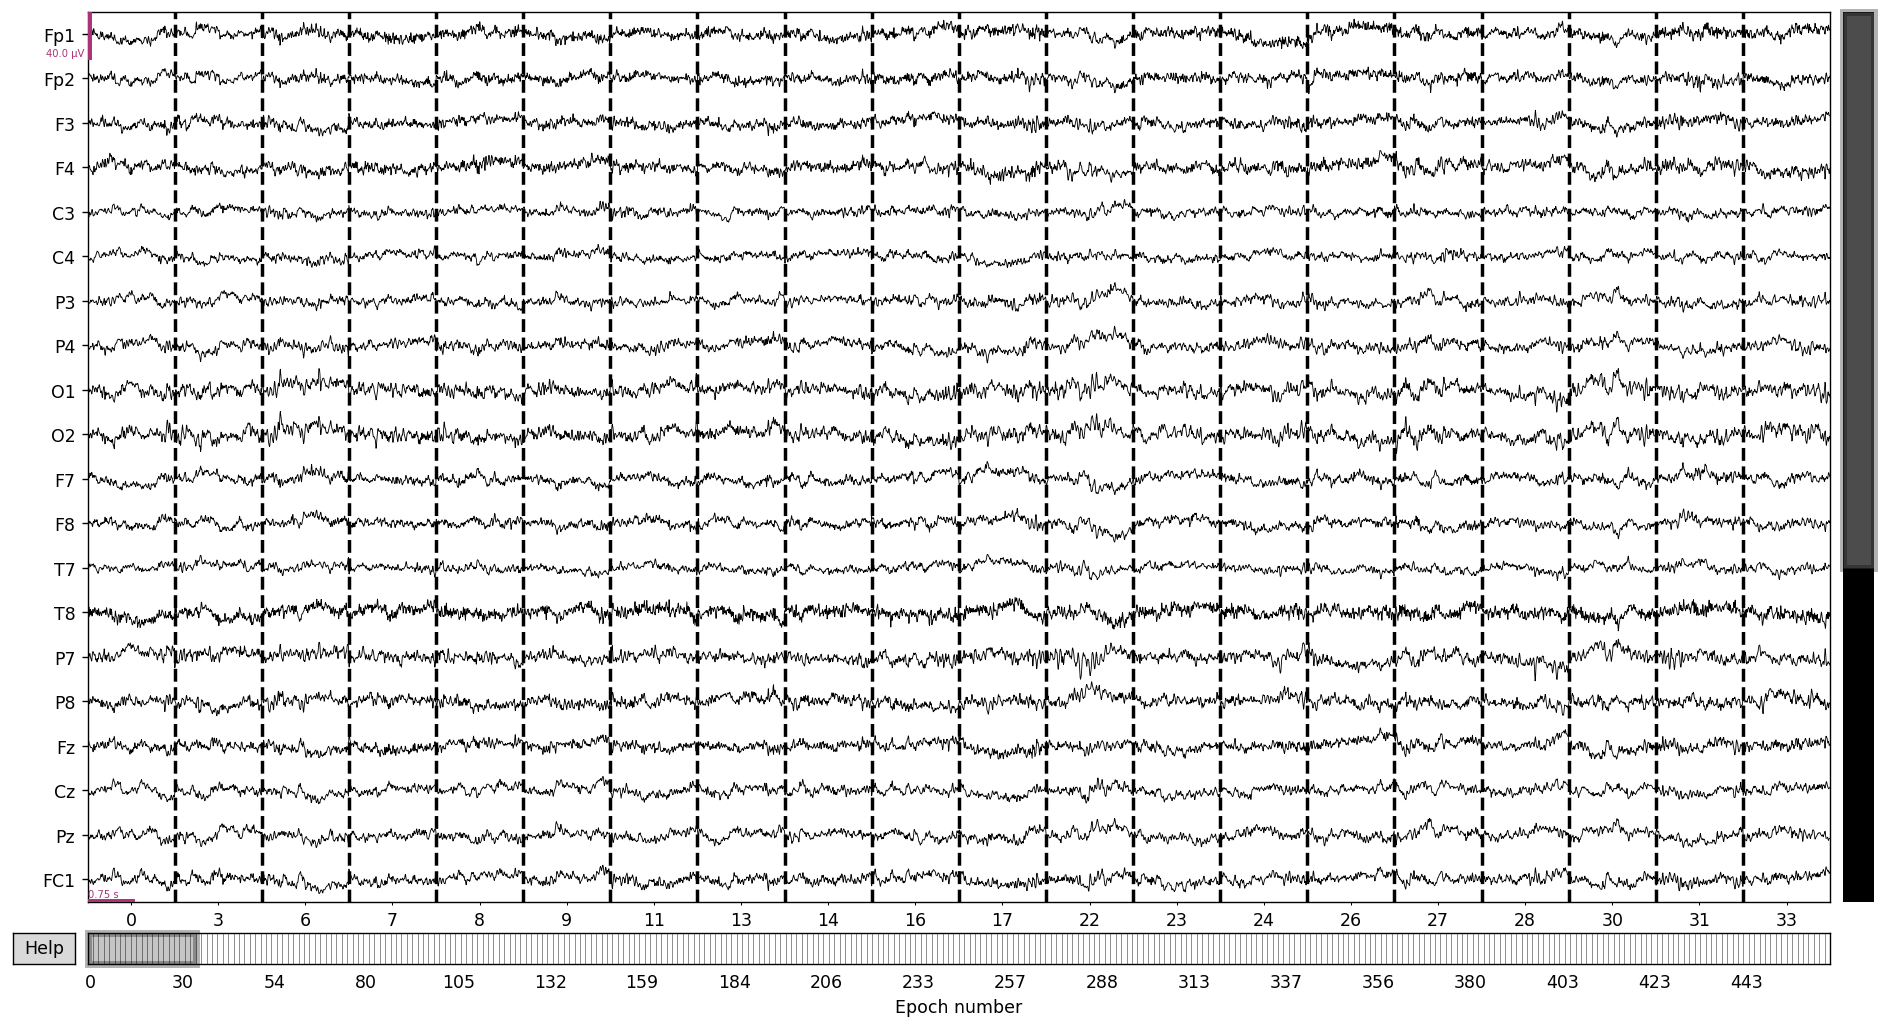

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [26]:
# Plot PSD of preprocessed epochs
if epochs_interpolate is not None:
    psd_epochs_fig = epochs_interpolate.plot_psd()
    plt.show()

    # Plot epochs browser for final inspection
    epochs_browser = epochs_interpolate.plot(block=False)
    print("Navegador de épocas creado. Puedes usarlo para inspección final de los datos.")
    print("Si el navegador no aparece, verifica que el backend de matplotlib esté configurado correctamente.")
else:
    print("Error: No hay épocas interpoladas disponibles para visualizar.")

### Plot ERPs for Campeones Analysis
Visualize the event-related potentials for the processed video stimuli. 
This helps validate the preprocessing and shows neural responses to the affective and luminance video conditions.

In [31]:
# Plot ERPs for the available conditions
# For the Campeones project, we'll plot the general evoked response
try:
    if epochs_interpolate is not None and len(epochs_interpolate) > 0:
        # Plot the overall average evoked response
        all_evoked = epochs_interpolate.average()
        erp_fig = all_evoked.plot_joint([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        plt.show()
        
        # Plot evoked topography at different time points
        topo_fig = all_evoked.plot_topomap([0.1, 0.2, 0.3, 0.4, 0.5])
        plt.show()
        
        print("Plots de ERPs creados exitosamente.")
        
        # If we have specific conditions, you can compare them here
        # For example, if you have affective vs luminance conditions:
        # affective_evoked = epochs_interpolate['affective'].average()
        # luminance_evoked = epochs_interpolate['luminance'].average()
        # Compare conditions if available
    else:
        print("No hay épocas disponibles para crear ERPs")
        
except Exception as e:
    print(f"Could not plot evoked responses: {e}")
    if epochs_interpolate is not None:
        print("Available event types:", list(epochs_interpolate.event_id.keys()))
    else:
        print("epochs_interpolate is None")

No projector specified for this dataset. Please consider the method self.add_proj.


In [ ]:
# Verificar y mostrar el report final
print("=== VERIFICACIÓN FINAL DE WIDGETS INTERACTIVOS ===")
print(f"Backend de matplotlib: {matplotlib.get_backend()}")

# Mostrar el report en el navegador
try:
    # Buscar el archivo de report generado
    html_files = [f for f in os.listdir(bids_dir) if f.endswith('.html') and 'report' in f.lower()]
    
    if html_files:
        latest_report = max(html_files, key=lambda x: os.path.getctime(os.path.join(bids_dir, x)))
        report_path = os.path.join(bids_dir, latest_report)
        
        print(f"Report encontrado: {latest_report}")
        print(f"Ubicación: {report_path}")
        
        # Guardar el report con la opción de abrir automáticamente
        report.save(report_path, overwrite=True, open_browser=True)
        print("Report guardado y abierto en el navegador por defecto.")
        
    else:
        print("No se encontró ningún archivo de report HTML.")
        # Crear uno nuevo
        report_path = os.path.join(bids_dir, f"sub-{subject}_ses-{session}_task-{task}_preprocessing_report.html")
        report.save(report_path, overwrite=True, open_browser=True)
        print(f"Nuevo report creado: {report_path}")
        
except Exception as e:
    print(f"Error al mostrar el report: {e}")

print("\n=== CHECKLIST DE WIDGETS INTERACTIVOS ===")
print("✓ ipympl y ipywidgets instalados")
print("✓ %matplotlib widget activado")  
print("✓ Plots con plt.show() agregados")
print("✓ Referencias a figuras guardadas (sensor_fig, browser, etc.)")
print("✓ Report guardado con open_browser=True")
print("\nSi los widgets no aparecen:")
print("1. Reinicia el kernel del notebook")
print("2. Ejecuta de nuevo las celdas desde el principio")
print("3. Verifica que estés en un entorno Jupyter compatible (JupyterLab, VS Code con extensión Jupyter)")
print("=============================================")

# Mostrar información sobre las figuras creadas
print(f"\nFiguras interactivas creadas:")
if 'sensor_fig' in locals():
    print("- Mapa de sensores (sensor_fig)")
if 'browser' in locals():
    print("- Navegador de datos raw (browser)")
if 'filtered_browser' in locals():
    print("- Navegador de datos filtrados (filtered_browser)")
if 'epochs_browser' in locals():
    print("- Navegador de épocas (epochs_browser)")
if 'psd_fig' in locals():
    print("- Gráfico PSD de datos filtrados (psd_fig)")
if 'psd_epochs_fig' in locals():
    print("- Gráfico PSD de épocas (psd_epochs_fig)")
if 'erp_fig' in locals():
    print("- Gráfico ERP conjunto (erp_fig)")
if 'topo_fig' in locals():
    print("- Mapas topográficos (topo_fig)")

print("\nTodas las figuras deben permanecer activas hasta que decidas cerrarlas.")
